In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/Preprocessed_Bank_Customer_Churn_Prediction.csv')

# # 사용할 피처 선택 (customer_id 제거)
features = ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary']

df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,0,1,42,2,0.00,1,1,1,101348.88,1
1,608,2,1,41,1,83807.86,1,0,1,112542.58,0
2,502,0,1,42,8,159660.80,3,1,0,113931.57,1
3,699,0,1,39,1,0.00,2,0,0,93826.63,0
4,850,2,1,43,2,125510.82,1,1,1,79084.10,0


In [2]:
from sklearn.metrics import roc_curve, auc

def auc_plot(model, X_test, y_test):
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [3]:
# log1p 변환 수행
skewed_columns = ['age', 'balance', 'estimated_salary', 'credit_score']

for column in skewed_columns:
    df[column] = df[column].apply(np.log1p)
    
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,6.429719,0,1,3.761200,2,0.000000,1,1,1,11.526334,1
1,6.411818,2,1,3.737670,1,11.336294,1,0,1,11.631096,0
2,6.220590,0,1,3.761200,8,11.980813,3,1,0,11.643362,1
3,6.551080,0,1,3.688879,1,0.000000,2,0,0,11.449215,0
4,6.746412,2,1,3.784190,2,11.740155,1,1,1,11.278280,0


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 정규화 (Normalization) - 0과 1 사이로 변환
scaler = StandardScaler()

X = df[features]
y = df['churn']

X = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [5]:
# %pip install catboost

In [6]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

ada_best_params = {
    'learning_rate': 1, 
    'n_estimators': 450
}

ada = AdaBoostClassifier(random_state=42, **ada_best_params)

cat_best_params = {
    'depth': 4, 
    'iterations': 100, 
    'learning_rate': 0.1
}
cat = CatBoostClassifier(random_state=42, **cat_best_params, verbose=0, class_weights=[1, 2.21])
# cat = CatBoostClassifier(random_state=42, **cat_best_params, verbose=0, class_weights=[1, 50])

xgb_best_params = {
'colsample_bytree': 0.998835926756326,
    'learning_rate': 0.05918736154295684,
    'max_depth': 4,
    'min_child_weight': 4,
    'n_estimators': 152,
    'subsample': 0.7171956369176462,
    'scale_pos_weight': 1.9,  # Recall 최적화된 비율
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
}
xgb = XGBClassifier(random_state=42, **xgb_best_params)

rf_best_params = {
    'n_estimators':200, 
    'max_depth':15, 
    'min_samples_leaf':2, 
    'min_samples_split':5
}
rf = RandomForestClassifier(random_state=42, **rf_best_params, verbose=0)

              precision    recall  f1-score   support

           0     0.8868    0.9380    0.9117      2389
           1     0.6871    0.5319    0.5996       611

    accuracy                         0.8553      3000
   macro avg     0.7870    0.7350    0.7557      3000
weighted avg     0.8461    0.8553    0.8482      3000



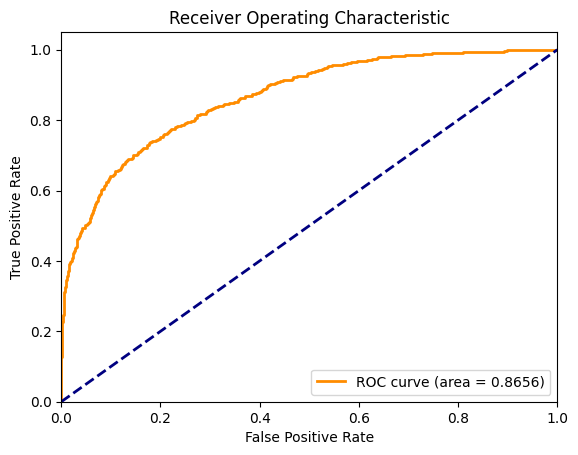

In [7]:
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier

estimators = [
    ('cat', cat),
    ('xgb', xgb),
    ('rf', rf),
    ('ada', ada)
]

voting = VotingClassifier(estimators=estimators, voting='soft')

voting.fit(X_train, y_train)

y_pred = voting.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

auc_plot(voting, X_test, y_test)

['cat' 'xgb' 'rf' 'ada']
              precision    recall  f1-score   support

           0     0.9062    0.8983    0.9022      2389
           1     0.6155    0.6367    0.6259       611

    accuracy                         0.8450      3000
   macro avg     0.7609    0.7675    0.7641      3000
weighted avg     0.8470    0.8450    0.8460      3000



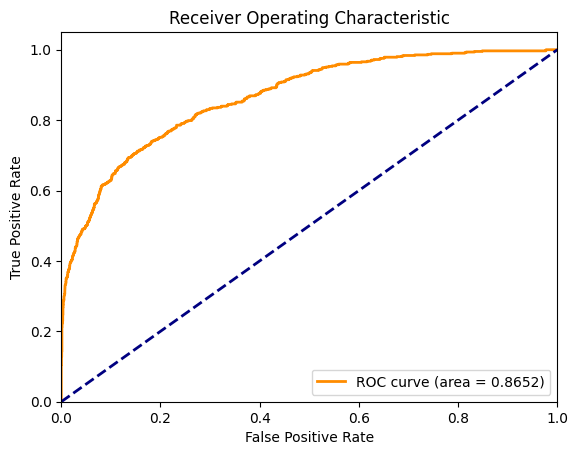

['cat' 'xgb' 'ada' 'rf']
              precision    recall  f1-score   support

           0     0.9053    0.9000    0.9026      2389
           1     0.6176    0.6318    0.6246       611

    accuracy                         0.8453      3000
   macro avg     0.7614    0.7659    0.7636      3000
weighted avg     0.8467    0.8453    0.8460      3000



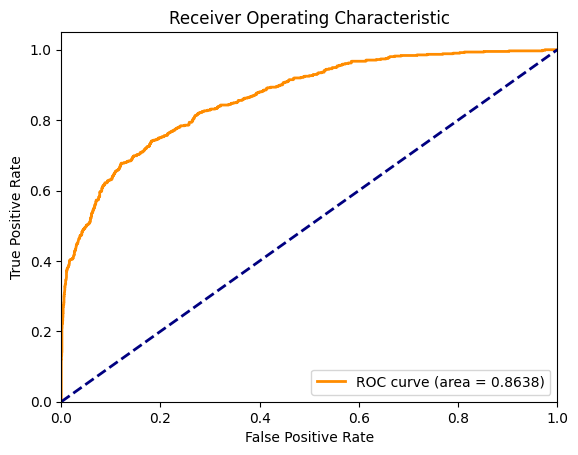

['cat' 'rf' 'xgb' 'ada']
              precision    recall  f1-score   support

           0     0.9050    0.9008    0.9029      2389
           1     0.6190    0.6301    0.6245       611

    accuracy                         0.8457      3000
   macro avg     0.7620    0.7655    0.7637      3000
weighted avg     0.8467    0.8457    0.8462      3000



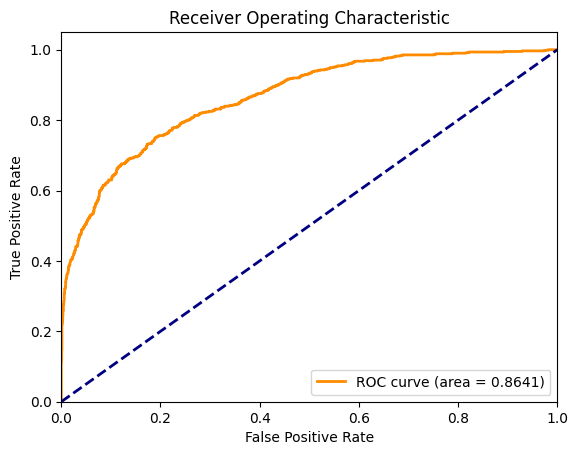

['cat' 'rf' 'ada' 'xgb']
              precision    recall  f1-score   support

           0     0.9055    0.9021    0.9038      2389
           1     0.6226    0.6318    0.6271       611

    accuracy                         0.8470      3000
   macro avg     0.7640    0.7669    0.7654      3000
weighted avg     0.8478    0.8470    0.8474      3000



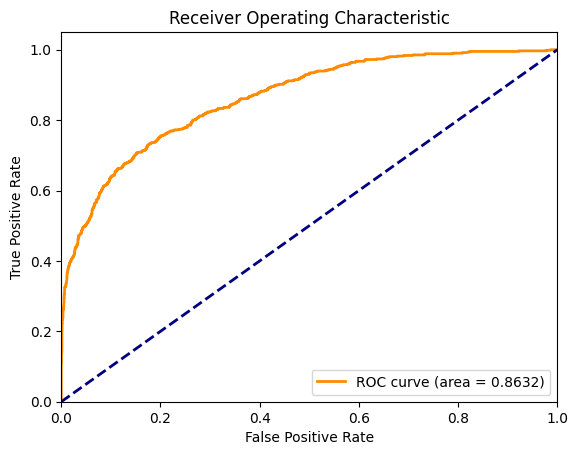

['cat' 'ada' 'xgb' 'rf']
              precision    recall  f1-score   support

           0     0.9068    0.9041    0.9055      2389
           1     0.6294    0.6367    0.6330       611

    accuracy                         0.8497      3000
   macro avg     0.7681    0.7704    0.7693      3000
weighted avg     0.8503    0.8497    0.8500      3000



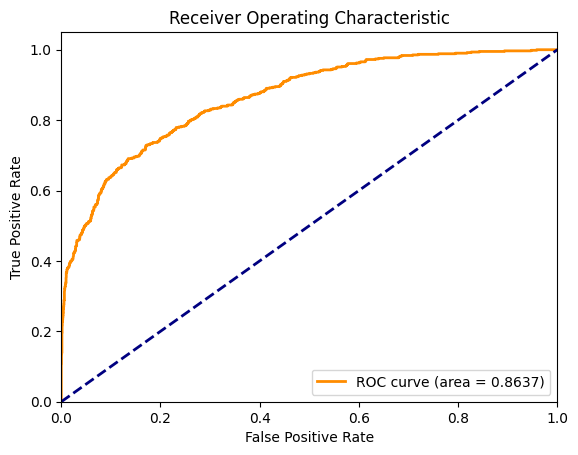

['cat' 'ada' 'rf' 'xgb']
              precision    recall  f1-score   support

           0     0.9042    0.9046    0.9044      2389
           1     0.6262    0.6252    0.6257       611

    accuracy                         0.8477      3000
   macro avg     0.7652    0.7649    0.7650      3000
weighted avg     0.8476    0.8477    0.8476      3000



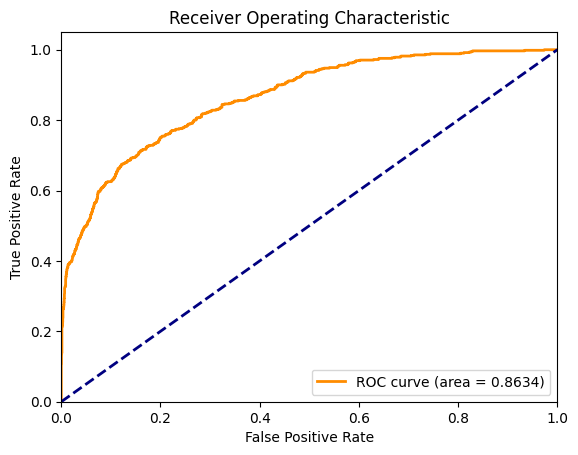

['xgb' 'cat' 'rf' 'ada']
              precision    recall  f1-score   support

           0     0.9019    0.9079    0.9049      2389
           1     0.6303    0.6137    0.6219       611

    accuracy                         0.8480      3000
   macro avg     0.7661    0.7608    0.7634      3000
weighted avg     0.8466    0.8480    0.8472      3000



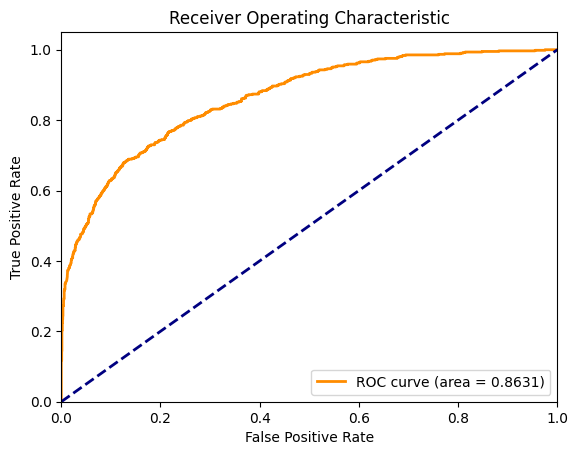

['xgb' 'cat' 'ada' 'rf']
              precision    recall  f1-score   support

           0     0.9023    0.9041    0.9032      2389
           1     0.6221    0.6170    0.6196       611

    accuracy                         0.8457      3000
   macro avg     0.7622    0.7606    0.7614      3000
weighted avg     0.8452    0.8457    0.8454      3000



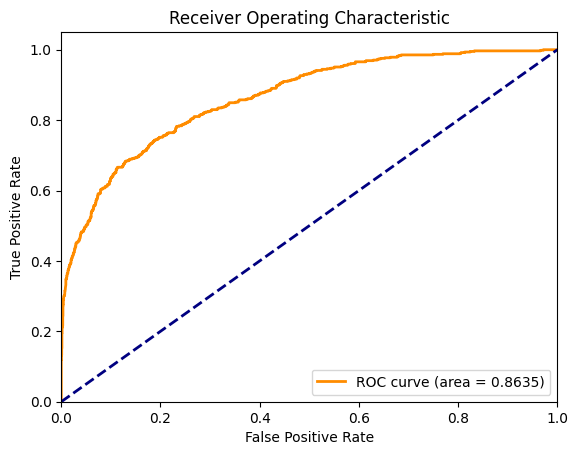

['xgb' 'rf' 'cat' 'ada']
              precision    recall  f1-score   support

           0     0.9034    0.9117    0.9075      2389
           1     0.6418    0.6187    0.6300       611

    accuracy                         0.8520      3000
   macro avg     0.7726    0.7652    0.7688      3000
weighted avg     0.8501    0.8520    0.8510      3000



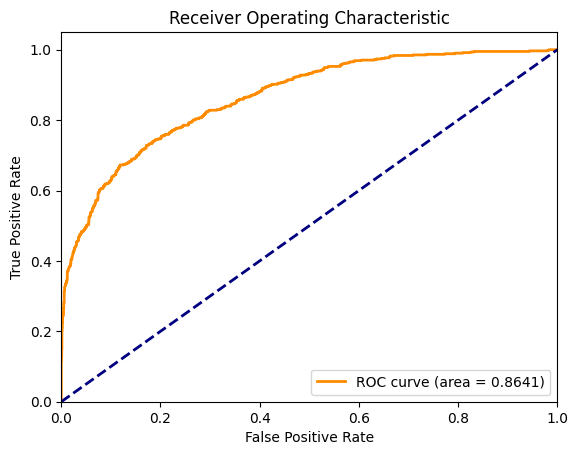

['xgb' 'rf' 'ada' 'cat']
              precision    recall  f1-score   support

           0     0.9024    0.9054    0.9039      2389
           1     0.6252    0.6170    0.6211       611

    accuracy                         0.8467      3000
   macro avg     0.7638    0.7612    0.7625      3000
weighted avg     0.8459    0.8467    0.8463      3000



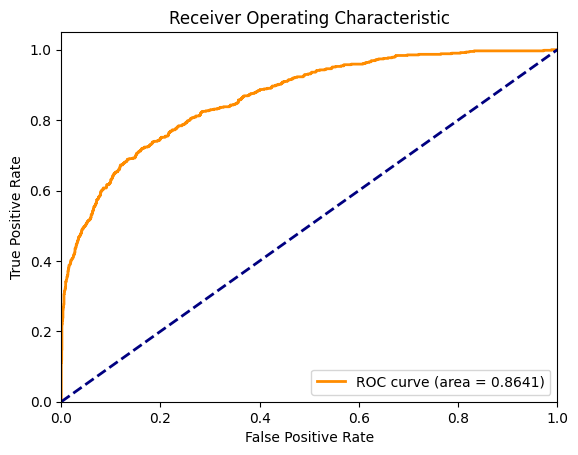

['xgb' 'ada' 'cat' 'rf']
              precision    recall  f1-score   support

           0     0.9039    0.9054    0.9046      2389
           1     0.6277    0.6236    0.6256       611

    accuracy                         0.8480      3000
   macro avg     0.7658    0.7645    0.7651      3000
weighted avg     0.8476    0.8480    0.8478      3000



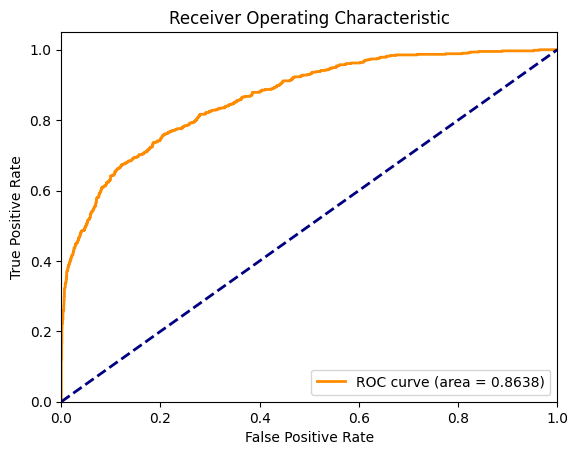

['xgb' 'ada' 'rf' 'cat']
              precision    recall  f1-score   support

           0     0.9035    0.9050    0.9042      2389
           1     0.6260    0.6219    0.6240       611

    accuracy                         0.8473      3000
   macro avg     0.7647    0.7635    0.7641      3000
weighted avg     0.8470    0.8473    0.8471      3000



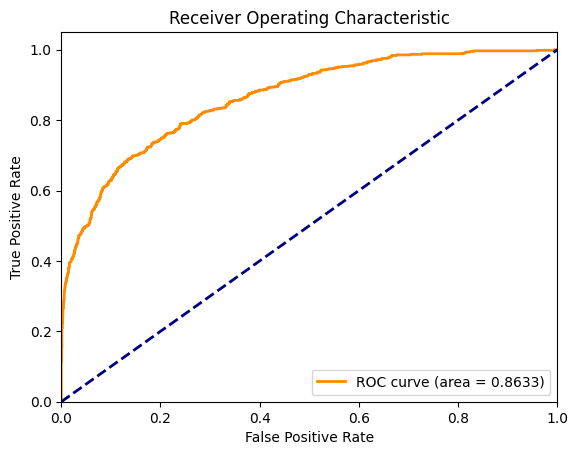

['rf' 'cat' 'xgb' 'ada']
              precision    recall  f1-score   support

           0     0.9028    0.9100    0.9064      2389
           1     0.6368    0.6170    0.6268       611

    accuracy                         0.8503      3000
   macro avg     0.7698    0.7635    0.7666      3000
weighted avg     0.8486    0.8503    0.8494      3000



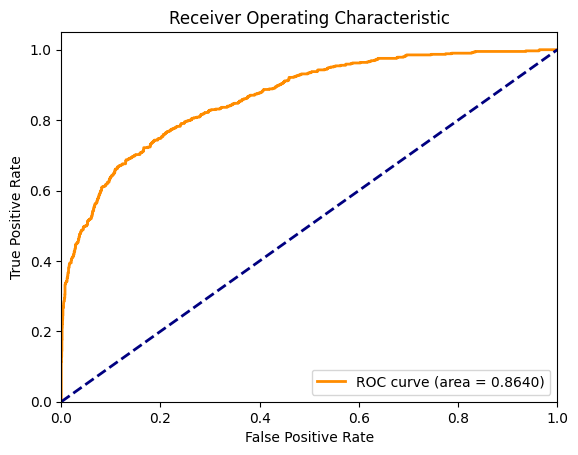

['rf' 'cat' 'ada' 'xgb']
              precision    recall  f1-score   support

           0     0.9048    0.8991    0.9020      2389
           1     0.6150    0.6301    0.6225       611

    accuracy                         0.8443      3000
   macro avg     0.7599    0.7646    0.7622      3000
weighted avg     0.8458    0.8443    0.8450      3000



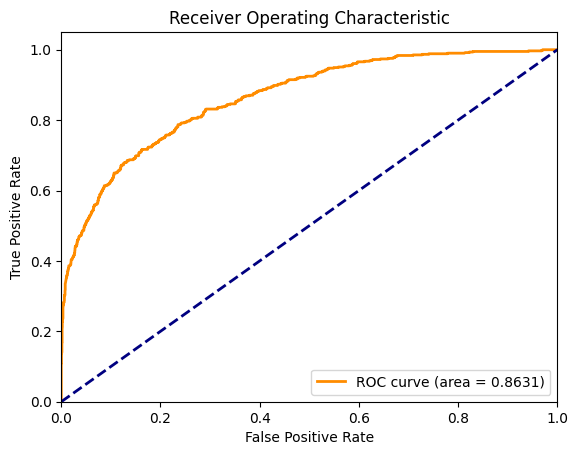

['rf' 'xgb' 'cat' 'ada']
              precision    recall  f1-score   support

           0     0.9025    0.9071    0.9048      2389
           1     0.6294    0.6170    0.6231       611

    accuracy                         0.8480      3000
   macro avg     0.7660    0.7620    0.7640      3000
weighted avg     0.8469    0.8480    0.8474      3000



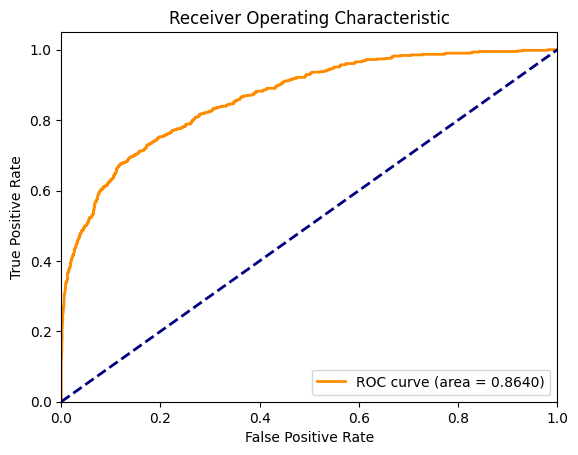

['rf' 'xgb' 'ada' 'cat']
              precision    recall  f1-score   support

           0     0.9037    0.9037    0.9037      2389
           1     0.6236    0.6236    0.6236       611

    accuracy                         0.8467      3000
   macro avg     0.7636    0.7636    0.7636      3000
weighted avg     0.8467    0.8467    0.8467      3000



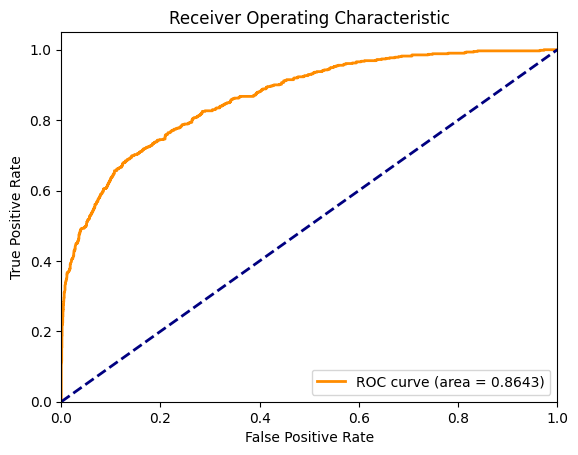

['rf' 'ada' 'cat' 'xgb']
              precision    recall  f1-score   support

           0     0.9048    0.9033    0.9041      2389
           1     0.6244    0.6285    0.6264       611

    accuracy                         0.8473      3000
   macro avg     0.7646    0.7659    0.7652      3000
weighted avg     0.8477    0.8473    0.8475      3000



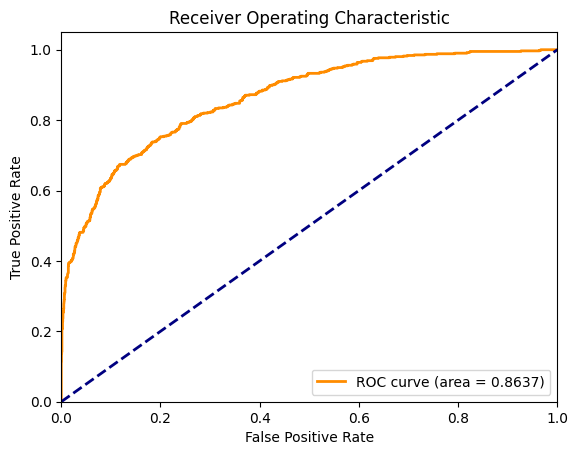

['rf' 'ada' 'xgb' 'cat']
              precision    recall  f1-score   support

           0     0.9018    0.9033    0.9026      2389
           1     0.6194    0.6154    0.6174       611

    accuracy                         0.8447      3000
   macro avg     0.7606    0.7593    0.7600      3000
weighted avg     0.8443    0.8447    0.8445      3000



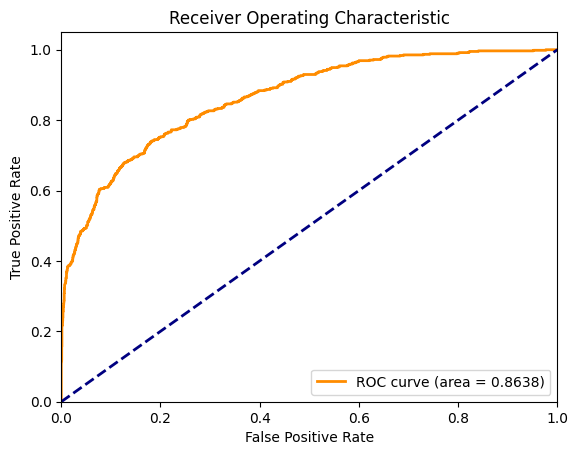

['ada' 'cat' 'xgb' 'rf']
              precision    recall  f1-score   support

           0     0.9054    0.9058    0.9056      2389
           1     0.6311    0.6301    0.6306       611

    accuracy                         0.8497      3000
   macro avg     0.7683    0.7680    0.7681      3000
weighted avg     0.8496    0.8497    0.8496      3000



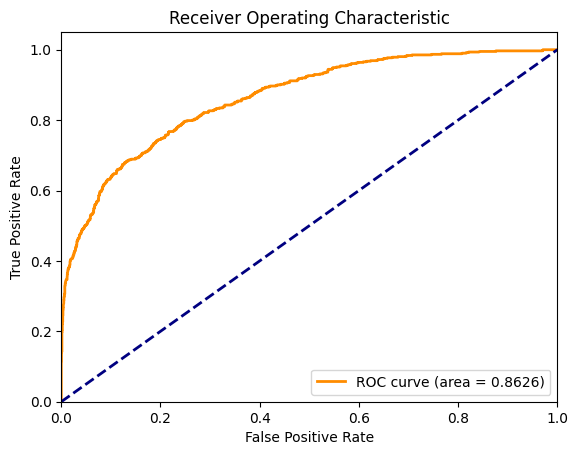

['ada' 'cat' 'rf' 'xgb']
              precision    recall  f1-score   support

           0     0.9047    0.9016    0.9031      2389
           1     0.6204    0.6285    0.6244       611

    accuracy                         0.8460      3000
   macro avg     0.7625    0.7651    0.7638      3000
weighted avg     0.8468    0.8460    0.8464      3000



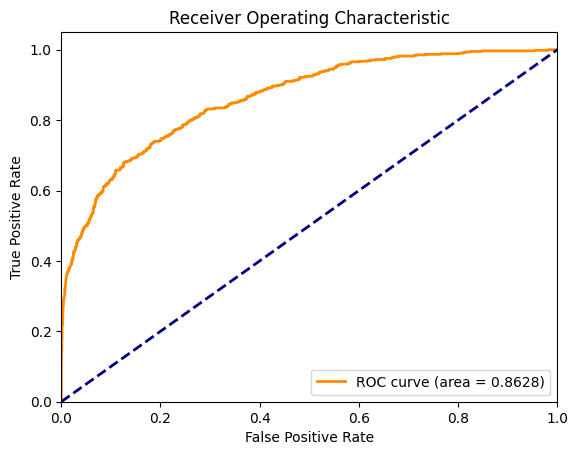

['ada' 'xgb' 'cat' 'rf']
              precision    recall  f1-score   support

           0     0.9022    0.9071    0.9046      2389
           1     0.6288    0.6154    0.6220       611

    accuracy                         0.8477      3000
   macro avg     0.7655    0.7612    0.7633      3000
weighted avg     0.8465    0.8477    0.8471      3000



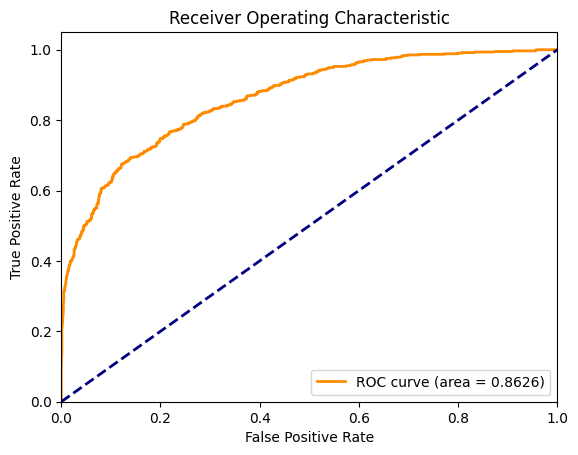

['ada' 'xgb' 'rf' 'cat']
              precision    recall  f1-score   support

           0     0.9038    0.9050    0.9044      2389
           1     0.6266    0.6236    0.6251       611

    accuracy                         0.8477      3000
   macro avg     0.7652    0.7643    0.7648      3000
weighted avg     0.8474    0.8477    0.8475      3000



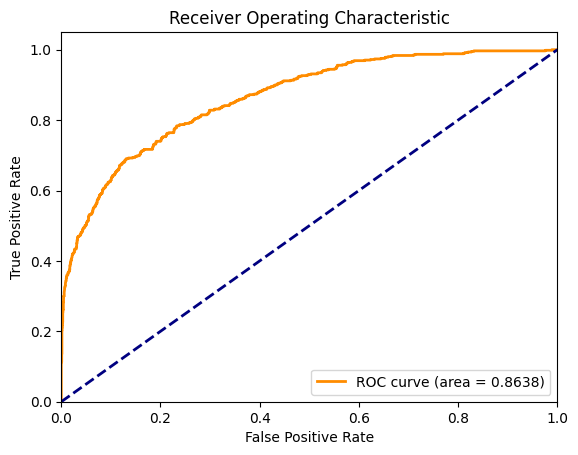

['ada' 'rf' 'cat' 'xgb']
              precision    recall  f1-score   support

           0     0.9042    0.9046    0.9044      2389
           1     0.6262    0.6252    0.6257       611

    accuracy                         0.8477      3000
   macro avg     0.7652    0.7649    0.7650      3000
weighted avg     0.8476    0.8477    0.8476      3000



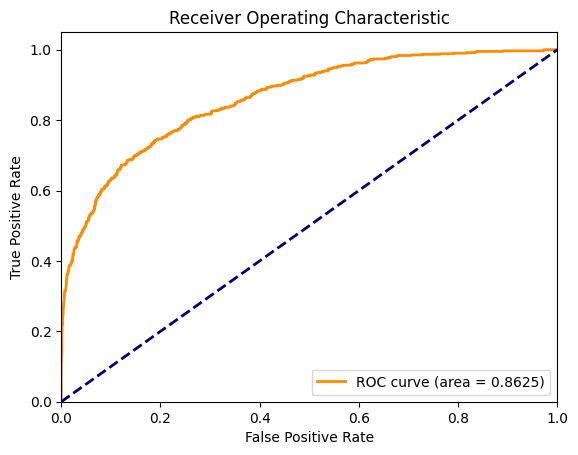

['ada' 'rf' 'xgb' 'cat']
              precision    recall  f1-score   support

           0     0.9050    0.9016    0.9033      2389
           1     0.6210    0.6301    0.6255       611

    accuracy                         0.8463      3000
   macro avg     0.7630    0.7659    0.7644      3000
weighted avg     0.8472    0.8463    0.8468      3000



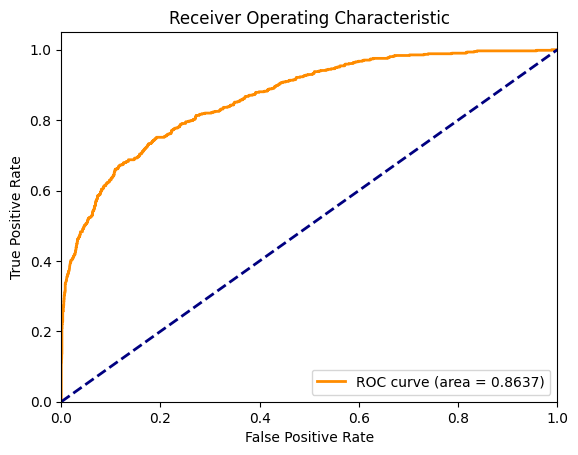

In [8]:
from itertools import permutations
from sklearn.ensemble import StackingClassifier

perms = list(map(list, permutations(estimators)))

for perm in perms:
    stacking = StackingClassifier(estimators=perm, final_estimator=cat, cv=5)

    stacking.fit(X_train, y_train)

    y_pred = stacking.predict(X_test)
    
    print(np.array(perm)[:, 0])
    
    print(classification_report(y_test, y_pred, digits=4))

    auc_plot(stacking, X_test, y_test)